# Characterizing data distribution

#### We want to represent the dataset in a human-friendly format to get a good impression of it. This is a kind of dataset "identity card".

- Data format : autoML

In [3]:
input_dir = 'sample_data/chems'
basename = 'chems'

## Characterization

### Visualization
- Scatter plot matrix
- Classes distribution
- Hierarchical clustering with heatmap matrix
- Hierarchical clustering with correlation matrix
- Principal components analysis (PCA)
- Linear discriminant analysis (LDA)
- T-distributed stochastic neighbor embedding (t-SNE algorithm)

### Meta features

- **Simple features, Simple Measurements or General Data Characteristic** are directly and easily accessible properties of the dataset wich need almost no computations such as number of classes or number of attributes.
    
    - Number of records: $n$
    - Number of attributes: $m$
    -  Number of classes: $q$
    -  Ratio of symbolic attributes: $\frac{m_{symb}}{m}$
    -  DatasetRatio $=\frac{NumberOfFeatures}{NumberOfInstances}$  
    -  Default error rate: $1 - Acc_{def}$ where $Acc_{def}$ is the probability of the largest class or default accuracy.
    -  Standard deviation of the class distribution: $\sigma_{class}$
    -  Relative probability of defective records: $\frac{n_{defTuple}}{n}$ where $n_{defTuple}$ is the number of records with missing values.
    -  Relative probability of missing values: $\frac{h_{missVal}}{n \times m}$ where $h_{missVal}$ is the number of missing values.

<br>   
- **Statistical features** use statistical analysis methods and tests (Engels and Theusinger, 1998; Sohn 1999).
    
    - Kurtosis: Fourth central moment divided by the square of the variance $\frac{E[(x_i-E[x_i])^4]}{[E[(x_i-E[x_i])^4]]^2}$ where $x_i$ is the ith feature. 
    - PCAKurtosis: Transform the dataset X by PCA, then compute the kurtosis
    - SkewnessMin: min over skewness of all features. Skewness measures the symmetry of a distribution. A skewness value > 0 means that there is more weight in the left tail of the distribution

<br> 
- **Discriminant Measurements** compute a discriminant analysis leading to the following measurements:
    
    -  Relative importance if the largest eigenvalue as an indication for the importance of the $1{\text{st}}$ discriminant function
    -  Canonical correlation, which is an indicator for the degree of correlation between the most significant discriminant function and class distribution. There is a strong correlation between the classes and the $1{\text{st}}$ discriminant function if this measurement is close to unity.
    -  Number of discriminant functions
    -  Wilks Lambda describes the significance of the r discriminant functions and is defined as follows:
        
        $$ \Lambda = \Pi^{DiscFct}_{j=1} \frac{1}{1 + \lambda_j} $$
        
        If Wlambda is near zero, in principle this indicates there is a good possibility for making good discriminations.

<br> 
-  **Information-theoric features** typically use entropy measures of the attributes and the class label (Segrera et al., 2008).
    
    -  ClassEntropy $= mean(-\sum_{i=1}^{n}p(Class_i)ln(p(Class_i)))$ where $p(Class_i)$ is the probability of having an instance of Class\_i
    -  Join entropy
    -  Average attribute entropy
    -  Average mutual information
    -  Relevance-measure
    -  Signal Noise Ratio

<br> 
-  **Model-based features** create a model of the data, e.g. a decision tree, and use properties of it, e.g. the width and height of the tree, as features (Peng et al., 2002 used 17 properties of a decision tree).

<br> 
-  **Landmarking features** apply fast computable classifiers, e.g. Naive Bayes or 1-Nearest Neighbor, on the dataset (Pfahringer et al., 2000; Bensusan and Giraud-Carrier, 2000) and use the resulting performance as meta-features. This can be done with several metrics.
    
    <!-- -  Landmark[Some\_Model]: accuracy of [Some\_Model] applied on dataset. -->
    <!-- -  LandmarkDecisionNodeLearner \& LandmarkRandomNodeLearner: Both are decision tree with max\_depth=1. `DecisionNode' considers all features when looking for best split, and `RandomNode' considers only 1 feature, where comes the term `random'. -->

<br> 
-  **Time-based features** are specialized for time predictions. They contain time measures of several computations regarding the dataset, e.g. the time for computing the other meta-features. Meta-features of this group have the benefit that they are able to take the performance of the computer into account. In (Reif et al., 2011) they present nine different time-measures.
    
    -  Training time ?
    -  Testing time ?

<!-- 
A voir : Algorithm Characteristics

ClassProbabilityMin $= min_{i=1 \dots n}(p(Class_i))= min_{i=1 \dots n}(\frac{NumberOfInstances\_Class_i}{TotleNumberOfInstances}) $

NumSymbols: For each categorial feature, compute how many unique values there is ???

Interpretability of the model ? -->

In [4]:
# Imports

# AutoML
problem_dir = 'data_manager/'  
from sys import path
path.append(problem_dir)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from auto_ml import AutoML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read data

In [5]:
#D = AutoML(input_dir, basename)
D = AutoML.from_csv(input_dir, basename, 'chemsdata.csv')

No info file file found.


In [6]:
D.show_info()

Task: Unknown
Format: Dense
Is sparse: 0
Train num: 844
Feat num: 43
Usage: No info file
Name: Chems
Has categorical: 0
Has missing: 0
Feat type: Mixed
Time budget: 600
Metric: Auc metric


In [7]:
data = D.get_data_as_df()
data['X'].head()

,IDNUM,SpMaxL,JDze,nHM,F01NN,F04CN,NssssC,nCb,Cpercent,nCp,...,C026,F02CN,nHDon,SpMaxBm,PsiiA,nN,SM6Bm,nArCOOR,nX,class
0,1.0,3.919,2.6909,0.0,0.0,0.0,0.0,0.0,31.4,2.0,...,0.0,0.0,0.0,2.949,1.591,0.0,7.253,0.0,0.0,1.0
1,2.0,4.170,2.1144,0.0,0.0,0.0,0.0,0.0,30.8,1.0,...,0.0,0.0,0.0,3.315,1.967,0.0,7.257,0.0,0.0,1.0
2,3.0,3.932,3.2512,0.0,0.0,0.0,0.0,0.0,26.7,2.0,...,0.0,0.0,1.0,3.076,2.417,0.0,7.601,0.0,0.0,1.0
3,4.0,3.000,2.7098,0.0,0.0,0.0,0.0,0.0,20.0,0.0,...,0.0,0.0,1.0,3.046,5.000,0.0,6.690,0.0,0.0,1.0
4,5.0,4.236,3.3944,0.0,0.0,0.0,0.0,0.0,29.4,2.0,...,0.0,0.0,0.0,3.351,2.405,0.0,8.003,0.0,0.0,1.0


### Simplification

For numerical variables:
    - Replace missing values, NaN, with the median
    - Replace +Inf by the maximum and -Inf by the minimum

For categorical variables:
    - Replace missing values by 'missing'
    - One hot encoding

- Normalization (mean or min-max)

# Visualization

** Descriptors **

Ratio: 0.0509478672985782
Skewness min: -2.294999757105556
Skewness max: 24.685734911570382
Skewness mean: 3.6091486813172593


** Plots **

Correlation matrix
X_train


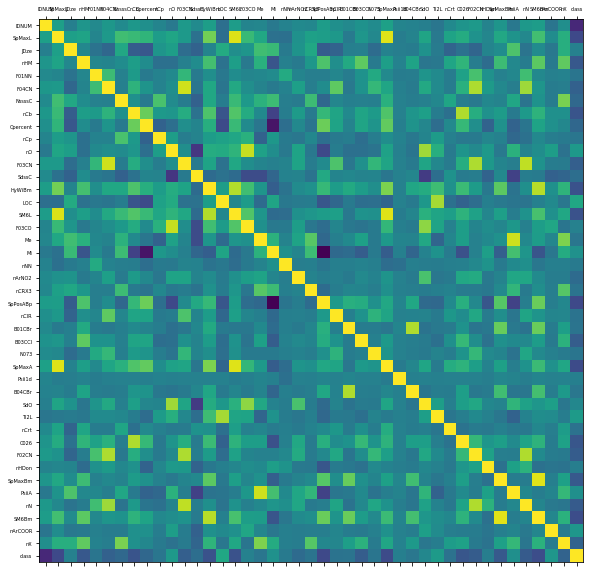

X_test


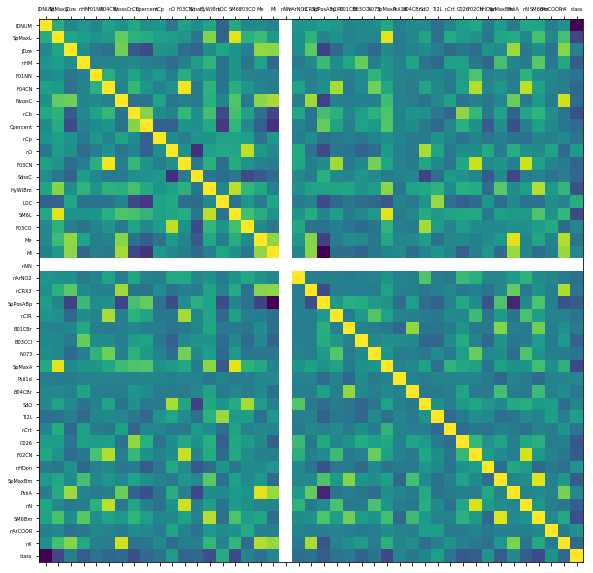

Hierarchical clustering heatmap
X_train

Performing hierarchical clustering using euclidean for columns and euclidean for rows
Column clustering completed in 0.1 seconds


data_manager/utilities.py:229: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  D2, method=column_method, metric=column_metric
data_manager/utilities.py:252: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  D1, method=row_method, metric=row_metric


Row clustering completed in 1.1 seconds


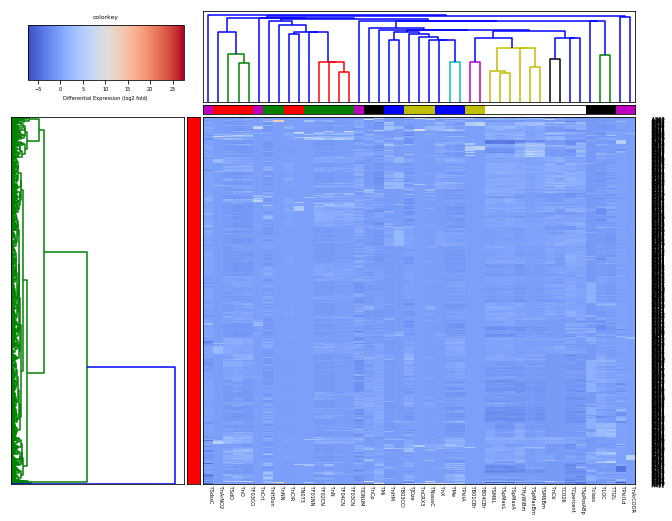

X_test

Performing hierarchical clustering using euclidean for columns and euclidean for rows


/usr/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:704: RuntimeWarning: invalid value encountered in greater_equal
  if np.all(y >= 0) and np.allclose(y, y.T):


ValueError: The condensed distance matrix must contain only finite values.

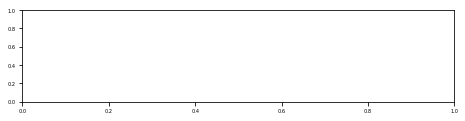

In [9]:
D.show_descriptors(processed_data=False)